In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import re
import sys
sys.path.append('../../util/')
# import sgt
from collections import Counter
from nltk.stem.snowball import EnglishStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle

In [2]:
st = EnglishStemmer()

In [3]:
# create a corpus to give to sklearn
def create_corpus_for_voc(df):
    doc = []
    for i in df.Text.tolist():
        #Remove some non-ascii characters and 'aa's
        i = re.sub(r'aA|aa', 'a', i)
        i = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', i)
        i = i.lower()
        doc.append(i)  
    return doc

In [4]:
# Get a vocabulary using sklearn's filtering
def get_voc(corpus, ngram, mindf):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(ngram,ngram),min_df=mindf)
    f = vectorizer.fit_transform(corpus)
    return set(sorted(vectorizer.get_feature_names()))

In [5]:
# compute unigram-frequency dict using the same preprocessing, using only words from the vocabulary
def create_unigram_freq_dict(df, voc):
    text = []
    for line in df.Text.tolist():
        line = re.sub(r'aA|aa', 'a', line)
        line = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', line).lower()
        line = re.findall(u'(?u)\\b\\w\\w+\\b', line)
        line = [st.stem(word) for word in line if word in voc]
        text.append(dict(Counter(line)))
    return text

In [6]:
def create_timelist(df):
    timelist = df.PublishDate.drop_duplicates().tolist()
    timelist = [str(i)[:7] for i in timelist]
    return sorted(list(set(timelist)))

In [7]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [8]:
# calculate unigram probabilities by simple Good Turing smoothing.
# imput: unigram-freq dict
# output: unigram-prob dict, mimic of a document-term matrix
# if unigram is in this doc, prob = the unigram prob calculated by sgt
# otherwise, prob = the probability given to "all unknown unigrams" by sgt
def calc_sgt(line_dict, voc):
    prob_line = []
    sgt_line = sgt.simpleGoodTuringProbs(line_dict)
    num_abs_words = len(voc - set(line_dict.keys()))
    for word in voc:
        if word in line_dict.keys():
            prob_line.append(sgt_line[0][word])
        else:
            prob_line.append(sgt_line[1]/float(num_abs_words))
    return prob_line

In [9]:
def calc_kl(p, q):
    return sum([p[i]*(np.log2(p[i]/q[i])) for i in range(len(p))])

In [10]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(100):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[2]
        head = sorted(aves)[97]
        return (ave_original, tail, head)

In [11]:
def calc_window_kl(df, min_df):
    # len(df_t) must > min_df
    # tune this for filtering?

    # output of the following pipeline:
    # a list of lists, each list containing sgt word probablity
    # word order is supposed to be the same
    corp = create_corpus_for_voc(df)
    sgt_list = []
    vocab = get_voc(corp,1,min_df)
    unigram_dict = create_unigram_freq_dict(df, vocab)
    for i in unigram_dict:
        sgt_list.append(calc_sgt(i, vocab))

    # calculate kl.
    # std: "standard work", average of the numpy matrix
    # calculate kl of each work - std work in each month
    # then use the average as kl of the month
    sgt_array = np.asarray(sgt_list)
#     std = np.mean(sgt_array, axis=0)
    kl_window = []
    for i in range(len(sgt_array)):
        for j in range(i+1, len(sgt_array)):
            kl = calc_kl(sgt_array[i],sgt_array[j])
            kl_window.append(kl)
    return [i for i in kl_window if not np.isnan(i) and not np.isinf(i)]

In [12]:
df = pd.read_csv('../../data/shakespare_william_works_preprocessed.tsv', sep = '\t')

In [15]:
# df['Author'].value_counts().head(1).index.tolist()[0]

'Lady_Loki'

In [17]:
min_df = 2
kl_Au_all = []
kl_nonAu_all = []
authors = df['Author'].drop_duplicates().tolist()
for author in authors:
    df_Au = df[df.Author == author]
    if len(df_Au) > 1:
        kl_Au = calc_window_kl(df_Au, min_df)
        kl_Au = bootstrap_resample(kl_Au)
        df_nonAu = df[df.Author != author]
        kl_nonAu = calc_window_kl(df_nonAu, min_df)
        kl_nonAu = bootstrap_resample(kl_nonAu)
        kl_Au_all.append(kl_Au)
        kl_nonAu_all.append(kl_nonAu)

99
p0 = 0.241781
Regression: log(z) = -2.346570*log(r) + 6.378936
p0 = 0.283237
Regression: log(z) = -2.181430*log(r) + 5.724200
p0 = 0.195082
Regression: log(z) = -2.085542*log(r) + 5.821099
p0 = 0.226457
Regression: log(z) = -2.282423*log(r) + 6.254448
p0 = 0.240376
Regression: log(z) = -2.318484*log(r) + 6.027175
p0 = 0.214112
Regression: log(z) = -2.271316*log(r) + 6.148041
p0 = 0.228807
Regression: log(z) = -2.344039*log(r) + 6.249469
p0 = 0.245317
Regression: log(z) = -2.393623*log(r) + 6.271575
p0 = 0.245740
Regression: log(z) = -2.374127*log(r) + 6.173034
p0 = 0.203184
Regression: log(z) = -2.281404*log(r) + 6.146719
p0 = 0.172751
Regression: log(z) = -2.158653*log(r) + 6.152354
p0 = 0.185185
Regression: log(z) = -2.221142*log(r) + 6.090240
p0 = 0.252560
Regression: log(z) = -2.179276*log(r) + 5.900457
p0 = 0.203645
Regression: log(z) = -2.043360*log(r) + 5.692864
p0 = 0.242537
Regression: log(z) = -2.354989*log(r) + 6.086672
p0 = 0.211306
Regression: log(z) = -2.263802*log(r) 

/Users/jingy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [7]:
kl_Au_all = pickle.load(open('kl_Au_all.p', 'rb'))
kl_nonAu_all = pickle.load(open('kl_nonAu_all.p', 'rb'))

In [5]:
kl_Au_all[0]

(1.0415093372693804, 1.0001447114426538, 1.0855094815601753)

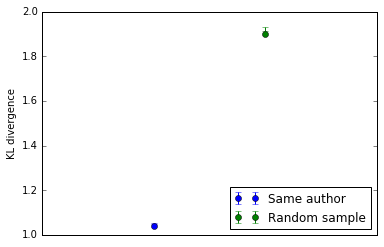

In [23]:
fig = plt.figure()
ax1 = plt.axes()
lower_error1 = [1.0403474308409972 - 1.0463718782461646]
upper_error1 = [1.0536013834657572 - 1.0403474308409972]
asymmetric_error1 =[lower_error1, upper_error1]
p1 = [1, 1.0403474308409972]

lower_error2 = [1.8987887570376696 - 1.912839459038669]
upper_error2 = [1.9294063426786272 - 1.8987887570376696]
asymmetric_error2 =[lower_error2, upper_error2]
p2 = [2, 1.8987887570376696]

plt.errorbar(p1[0], p1[1], yerr=asymmetric_error1,fmt='o', label='Same author')
plt.errorbar(p2[0], p2[1], yerr=asymmetric_error2,fmt='o', label='Random sample')
plt.xlim(0,3)
plt.legend(loc='lower right')
ax1.axes.get_xaxis().set_visible(False)
plt.ylabel('KL divergence')

plt.savefig('kl_validation.png', format = 'png')


In [35]:
lower_error1 = np.average( [i[0] for i in kl_Au_all]) - np.average([i[1] for i in kl_Au_all] )
upper_error1 = np.average([i[2] for i in kl_Au_all]) - np.average( [i[0] for i in kl_Au_all])
print(lower_error1, upper_error1)

0.0597381138357 0.0606873135631


In [38]:
lower_error2 = np.average([i[0] for i in kl_nonAu_all]) - np.average([i[1] for i in kl_nonAu_all]) 
upper_error2 =  np.average([i[2] for i in kl_nonAu_all]) -np.average([i[0] for i in kl_nonAu_all])
print(lower_error2, upper_error2)

0.0904250856214 0.0940191186992


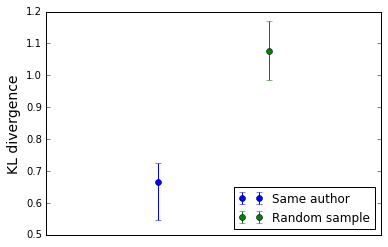

In [40]:
fig = plt.figure()
ax1 = plt.axes()
lower_error1 = [0.120425427399]
upper_error1 = [0.0606873135631]
asymmetric_error1 =[lower_error1, upper_error1]
p1 = [1, np.average([i[1] for i in kl_Au_all])]

lower_error2 = [0.0904250856214]
upper_error2 = [0.0940191186992]
asymmetric_error2 =[lower_error2, upper_error2]
p2 = [2, np.average([i[1] for i in kl_nonAu_all])]


plt.errorbar(p1[0], p1[1], yerr=asymmetric_error1,fmt='o', label='Same author')
plt.errorbar(p2[0], p2[1], yerr=asymmetric_error2,fmt='o', label='Random sample')
plt.xlim(0,3)
plt.legend(loc='lower right')
ax1.axes.get_xaxis().set_visible(False)
plt.ylabel('KL divergence', fontsize = 14)

plt.savefig('kl_validation.png', format = 'png')
